## M6 W5 Assignment: NLP

Natural language processing (NLP) is an important and rapidly developing part of machine learning. New powerful  models (the so-called transformer type) appear regularly and each new one outperforms the previous one in a fundamental NLP task, such as question-answering, name-entity recognition, etc. However, often simple, classical methods tend to work quite well and are a good first approach to solve many NLP problems.

In this assignment, I will work with a famous data set for sentiment analysis, namely the Amazon reviews data set. One place where the data can be found is here: https://www.kaggle.com/bittlingmayer/amazonreviews

Tasks for this assignment:

1) Create a new feature, called ‘n_tokens’ that counts how many tokens(words) there are in a review. In other words, a feature for the length of a review.  

2) Create a new feature, called ‘language’, which detects what is the language of each review. So this feature will have a different value for each row (review) of the data.

3) Transform each review into a numeric vector of tokens using a bag-of-words. Use can use the CountVectorizer module from sklearn but limit the maximum number of features to be 1000 to avoid memory issues (you can decrease it further if you still have memory issues). Explore the other parameters of the function as well.

4) Using the fitted and transformed vector and the above created features, train a model that predicts the sentiment of a review. Note that this will be a classification problem. Evaluate your model and motivate your choice of a performance metric.

In [1]:
#Import packages
%matplotlib inline

import bz2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
from polyglot.detect import Detector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [2]:
#Import data
train_file = bz2.BZ2File("train.ft.txt.bz2")

#Set seed for repeatability and select a random sample of 50000 lines
random.seed(42)
line_list = random.sample(train_file.readlines(), k=50000)
lines = [x.decode('utf-8') for x in line_list]

# Split in two: sentiment and review
sentiment = [review.split("__label__")[1][0] for review in lines]
reviews = [review.split("__label__")[1][1:]  for review in lines]

#Create list with sentiment and reviews
newlist = []
for i in range(len(sentiment)):
    newlist.append([sentiment[i], reviews[i]])

#Convert list to DataFrame
df = pd.DataFrame(newlist, columns = ['score', 'review'])
df.head()

,score,review
0,2,"I haven't buy this, but...: In flames es la n..."
1,1,Would not recommend: I bought this printer tw...
2,1,Former Dune Fan: OK - I am done with Dune. Th...
3,1,The trailer fooled me for once.: This film wa...
4,1,Did not like: I did not like this spray and g...


In [3]:
#EDA
rows, columns = df.shape
print('The data has {} columns and {} rows \n'.format(columns, rows))
print('Missing data:\n', df.isnull().sum())

The data has 2 columns and 50000 rows 

Missing data:
 score     0
review    0
dtype: int64


<function matplotlib.pyplot.show(*args, **kw)>

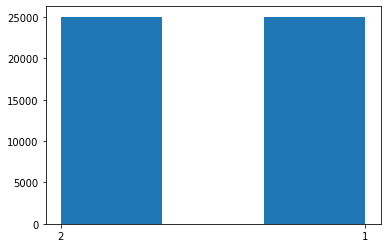

In [4]:
_ = plt.hist(df.score, bins=3)
plt.show

In [5]:
df.score.describe()

count     50000
unique        2
top           2
freq      25042
Name: score, dtype: object

We can see that there are no missing values in the data and that the data is quite eveny spread between positive (`2`) and negative (`1`) reviews.

Let's move to the counting the number of tokens (words) in each review.

In [6]:
df['n_tokens'] = [len(re.findall(r'\w+', line)) for line in df.review]

In [7]:
df.head(10)

,score,review,n_tokens
0,2,"I haven't buy this, but...: In flames es la n...",41
1,1,Would not recommend: I bought this printer tw...,71
2,1,Former Dune Fan: OK - I am done with Dune. Th...,107
3,1,The trailer fooled me for once.: This film wa...,121
4,1,Did not like: I did not like this spray and g...,41
5,1,yuck: if one could synthesize all that is bad...,38
6,1,"bland: Larry, as always, displays fine techni...",69
7,1,Devastatingly disappointing: The first two bo...,170
8,1,DANGEROUS- plastic and wire screen ended up i...,134
9,2,Great tick repellent: For someone who has suf...,24


We can now see that the number of words has been computed and added as a column called `n_tokens` using the above list comprehension. Next let's look at detecting the language of each review.

In [8]:
df['language'] = df.review.apply(lambda x: Detector(x, quiet=True).language.name)
df.head()

,score,review,n_tokens,language
0,2,"I haven't buy this, but...: In flames es la n...",41,Spanish
1,1,Would not recommend: I bought this printer tw...,71,English
2,1,Former Dune Fan: OK - I am done with Dune. Th...,107,English
3,1,The trailer fooled me for once.: This film wa...,121,English
4,1,Did not like: I did not like this spray and g...,41,English


Let's check for rows which have not been recorded as English.

In [9]:
with pd.option_context('display.max_colwidth', 62):
    print(df[df['language'] != 'English'][['review', 'language']])

                                                              review language
0       I haven't buy this, but...: In flames es la neta asì que ...  Spanish
493     uihuih: uyytui gyuh k !èyui hjuyuy ihuhui jhihui jhuiytfr...     Zulu
621     TRACK LIST: mael Rivera / Traigo De TodoLabel: TicoYear: ...  Spanish
720     sadly: lo ascolto è pregiudicato in positivo dalla conosc...  Italian
2029    Magnífica recopilación de J. Iglesias: En un artista como...  Spanish
...                                                              ...      ...
49086   Malo: La calidad de video que da este cable es malisima! ...  Spanish
49164   Adoro a Jane Austen: Si bien, son buenas adaptaciones de ...  Spanish
49408   "UN VERDADERO PRINCIPE EN SU SALSA": Despues de 5 años de...  Spanish
49451   Es bueno: Me gusto en cuanto a diseño pero yo estaba acos...  Spanish
49553   Excellent: Un excellent livre avec des questions_reponses...   French

[123 rows x 2 columns]


On inspection of the sample above it appears that languages have been recorded accurately.

In [10]:
#Let's look at unique languages
print(df.language.unique())

['Spanish' 'English' 'Zulu' 'Italian' 'French' 'Portuguese' 'Slovenian'
 'un' 'Dutch' 'Volapük' 'Norwegian Nynorsk' 'Polish' 'German']


In [11]:
#Let's create a count bag of words vector on the reviews column
count_vectorizer = CountVectorizer(stop_words=['english','spanish', 'zulu', 'italian', 'french',\
                                               'portuguese', 'slovenian', 'dutch', 'volapük',\
                                               'norwegian', 'polish', 'german'], max_features=1000)
review_counts = count_vectorizer.fit_transform(df.review)

In [12]:
#Create dataframe with review counts
count_df = pd.DataFrame(review_counts.A, columns=count_vectorizer.get_feature_names())
count_df.head()

,10,100,12,15,20,30,50,able,about,absolutely,...,wrong,wrote,year,years,yes,yet,you,young,your,yourself
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#Now let's concat the dataframes
df2 = pd.concat([df, count_df], axis=1)
df2.head()

,score,review,n_tokens,language,10,100,12,15,20,30,...,wrong,wrote,year,years,yes,yet,you,young,your,yourself
0,2,"I haven't buy this, but...: In flames es la n...",41,Spanish,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Would not recommend: I bought this printer tw...,71,English,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,1,Former Dune Fan: OK - I am done with Dune. Th...,107,English,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,1,The trailer fooled me for once.: This film wa...,121,English,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Did not like: I did not like this spray and g...,41,English,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#For the sake of machine learning let's remove the review column and use get_dummies on the language column
df3 = df2.drop('review', axis=1)
df3 = pd.get_dummies(df3, columns=['language'], drop_first=True)
df3.head()

,score,n_tokens,10,100,12,15,20,30,50,able,...,language_Portuguese,language_Slovenian,language_Spanish,language_Volapük,language_Zulu,language_un,language_1,language_2,language_3,language_5
0,2,41,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,71,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,107,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,121,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,41,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now I will train a model on this new dataframe which includes the bag of words and new features, `n_tokens` and `language`.

In [15]:
#The multinomial Naive Bayes classifier is suitable for classification with discrete features
#First create test and train data

y = df3['score']
X = df3.drop('score', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
#Next set up model

model = MultinomialNB()

#define parameter to test
params = {
    'alpha': np.arange(0.1, 1, 0.2),
    }

In [18]:
#use GridSearchCV to find best parameters
grid = GridSearchCV(model, params, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
best = grid.best_params_

#look at accuracy
confusion = metrics.confusion_matrix(y_test, y_pred)
clf = metrics.classification_report(y_test, y_pred)
print('Confusion matrix: \n', confusion, '\n')
print('Classification report: \n', clf, '\n')
print('Best parameters: \n', best, '\n')

Confusion matrix: 
 [[6914 1326]
 [1384 6876]] 

Classification report: 
               precision    recall  f1-score   support

           1       0.83      0.84      0.84      8240
           2       0.84      0.83      0.84      8260

    accuracy                           0.84     16500
   macro avg       0.84      0.84      0.84     16500
weighted avg       0.84      0.84      0.84     16500
 

Best parameters: 
 {'alpha': 0.9000000000000001} 



### Conclusion

Looking at the confusion matrix it can be seen that there is almost an equal split with the prediction of positive and negative reviews, which mirrors the equal split of the data.

With `alpha` at 0.9 The precision score is 0.84 and is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

### Further work

With more processing power I would investigate the performance of other classifiers and build an ensemble. In addition I would like to be able to use the full train data set and use it on the full test data set (not used in this assignment) to see if this would also improve accuracy.